# 기본 세팅

In [ ]:
#! pip install gcsfs

In [ ]:
#! pip install koreanize_matplotlib

In [ ]:
#!pip install seaborn

In [1]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import os

# GCS 파일 경로에서 데이터 불러오기 위한 라이브러리
from google.cloud import storage
from google.oauth2 import service_account

In [3]:
# Pandas 보기 옵션
# pd.set_option('display.max_columns',100)
# pd.set_option('display.max_rows',100)

In [2]:

# 기본 정보 확인 함수 
def show_df_info(df, df_name):
    """
    DataFrame의 기본 정보와 통계 요약을 출력하는 함수
    """
    print(f"\n{df_name} 형태:")
    display(df.shape)
    print(f"\n{df_name} 첫 5행:")
    display(df.head())
    print(f"\n{df_name} 정보:")
    df.info()
    print(f"\n{df_name} 통계 요약:")
    display(df.describe())
    print(f"\n{df_name} 통계 요약:")
    display(df.describe(include = 'O'))
    print(f"\n{df_name} 결측치 확인:")
    display(df.isnull().sum())
    # print(f"\n{df_name} 중복값 확인:")
    # print(df.iloc[:,1:].duplicated().sum())

# 데이터 불러오기 및 확인

In [3]:
# 인증
key_path = "../config/codeit_project_vm_key.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

# GCS 클라이언트 생성
client = storage.Client(credentials=credentials)
bucket = client.bucket("part4_project")

# 'hackle/' 경로에 있는 .parquet 파일 리스트 가져오기
blobs = bucket.list_blobs(prefix="hackle/")
hackle_file_list = [f"gs://part4_project/{blob.name}" for blob in blobs if blob.name.endswith(".parquet")]

# 결과 확인
hackle_file_list

['gs://part4_project/hackle/device_properties.parquet',
 'gs://part4_project/hackle/hackle_events.parquet',
 'gs://part4_project/hackle/hackle_properties.parquet',
 'gs://part4_project/hackle/user_properties.parquet']

In [4]:
# 파일들을 각각 변수로 불러오기
for title in hackle_file_list:
    # GCS 경로에서 파일명 추출
    file_name = title.split('/')[-1].replace('.parquet', '')
    
    # Parquet 파일 읽기
    df = pd.read_parquet(title, storage_options={"token": key_path})
    
    # 각각의 이름_df로 저장 (ex. device_properties_df)
    globals()[f"{file_name}_df"] = df
    
    # 선택적으로 출력 확인
    print(f"{file_name}_df 불러오기 완료, shape: {df.shape}")


device_properties_df 불러오기 완료, shape: (252380, 4)
hackle_events_df 불러오기 완료, shape: (11441319, 11)
hackle_properties_df 불러오기 완료, shape: (525350, 8)
user_properties_df 불러오기 완료, shape: (230819, 5)


# EDA

## 1. hackle_properties

|테이블명|	컬럼명	|컬럼 설명|
|-------|----------|--------|
|hackle_properties|	session_id|	세션 식별자|
|		|user_id|	사용자 ID|
|		|language|	사용 언어|
|		|osname|	운영 체제 이름|
|		|osversion|	운영 체제 버전|
|		|versionname|	앱 버전 이름|
|		|device_id|	장치 ID|

In [27]:
show_df_info(hackle_properties_df, 'hackle_properties_df')


hackle_properties_df 형태:


(525350, 8)


hackle_properties_df 첫 5행:


,id,session_id,user_id,language,osname,osversion,versionname,device_id
0,1,4OzYh3seq3VKytpSn5pvQkZNQii1,,ko-KR,iOS,16.0,2.0.0,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74
1,2,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,1046711,ko-KR,iOS,16.5.1,2.0.3,D5417226-F71B-4A9E-A180-CD072F2AB279
2,3,6bcea65d-9f40-46fc-888c-700fe707483f,1545130,ko,Android,13,2.0.5,6bcea65d-9f40-46fc-888c-700fe707483f
3,4,XVYNT6zfhFWqIg9omwg2AHDjTLx2,1224793,ko,Android,13,2.0.5,a05c1595-3e05-434b-8684-218b528bd725
4,5,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,1329450,ko-US,iOS,16.5.1,2.0.5,EAC6C0B3-7CE8-40EA-8A91-9977C0BA5EF3



hackle_properties_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525350 entries, 0 to 525349
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           525350 non-null  int64 
 1   session_id   525350 non-null  object
 2   user_id      525350 non-null  object
 3   language     525350 non-null  object
 4   osname       525350 non-null  object
 5   osversion    525350 non-null  object
 6   versionname  525350 non-null  object
 7   device_id    525350 non-null  object
dtypes: int64(1), object(7)
memory usage: 32.1+ MB

hackle_properties_df 통계 요약:


,id
count,525350.000000
mean,262675.500000
std,151655.626297
min,1.000000
25%,131338.250000
50%,262675.500000
75%,394012.750000
max,525350.000000



hackle_properties_df 통계 요약:


,session_id,user_id,language,osname,osversion,versionname,device_id
count,525350,525350,525350,525350,525350,525350,525350
unique,253616,327381,151,2,74,16,251720
top,040914e1-61ac-40ef-b76a-718066d880dc,,ko-KR,iOS,16.5.1,2.0.5,040914e1-61ac-40ef-b76a-718066d880dc
freq,9,82255,340900,359479,218699,309644,9



hackle_properties_df 결측치 확인:


id             0
session_id     0
user_id        0
language       0
osname         0
osversion      0
versionname    0
device_id      0
dtype: int64

In [ ]:
# id 컬럼 제외하고 중복 확인 - 없음
hackle_properties_df.iloc[:,1:].duplicated().sum()

0

In [28]:
# user_id 가 공백??
hackle_properties_df[hackle_properties_df['user_id'] == ''].shape

(82255, 8)

- user_id가 공백으로 입력되어 있는 경우 82255 개 
- 해당 경우 'unknown' 으로 변경

In [29]:
# user_id에 공백만 입력된 경우 'unknown'으로 변경
hackle_properties_df['user_id'] = hackle_properties_df['user_id'].apply(lambda x: 'unknown' if isinstance(x, str) and x.strip() == '' else x)
hackle_properties_df['user_id'].value_counts()

user_id
unknown    82255
1578652       17
1459833       13
1571506       13
1239584       12
           ...  
1085617        1
1499469        1
1075954        1
1021052        1
1043127        1
Name: count, Length: 327381, dtype: int64

- 공백만 unknown으로 변경된 것 확인! (개수 동일하게 82255개)

In [41]:
# session_id마다 user_id는 몇 개? (hackle_events에서 session_id를 user_id와 동일 취급 가능한가?)
session_user_cnt_df = hackle_properties_df.groupby('session_id')['user_id'].nunique().reset_index(name = 'user_id_count').sort_values(by ='user_id_count', ascending = False)
session_user_cnt_df

,session_id,user_id_count
1129,040914e1-61ac-40ef-b76a-718066d880dc,6
3209,0CC53548-EB9A-4AE5-A72E-5D765B3BB1F9,4
75081,B941F9F9-CF53-4DAE-A204-75E666B5D277,4
14354,23235867-49A8-4240-8B34-6342357440F9,4
56337,87046FBA-B84B-4124-ADE9-EA03DF95E7B8,4
...,...,...
56361,871DDDB5-20CC-4076-8CEC-A5087B69C72A,1
161330,ZRKVAinfU8NVuLTBKnlrsT7P9453,1
161329,ZRJnnLID7XUiXzlNnQEXywhpNWl2,1
56362,871E5518-6794-43AD-923F-2465934E709F,1


In [45]:
print(session_user_cnt_df['user_id_count'].value_counts())
print(session_user_cnt_df['user_id_count'].value_counts(normalize = True))

user_id_count
2    148802
1    101802
3      3007
4         4
6         1
Name: count, dtype: int64
user_id_count
2    0.586722
1    0.401402
3    0.011857
4    0.000016
6    0.000004
Name: proportion, dtype: float64


In [40]:
# user_id마다 session_id는 몇 개? (hackle_events에서 session_id를 user_id와 동일 취급 가능한가?)
user_session_cnt_df = hackle_properties_df.groupby('user_id')['session_id'].nunique().reset_index(name='session_id_count').sort_values(by='session_id_count', ascending=False)
user_session_cnt_df

,user_id,session_id_count
319303,unknown,78197
158764,1459833,13
195272,1578652,13
192533,1571506,13
210229,855879,12
...,...,...
109620,1302497,1
109619,1302488,1
109618,1302487,1
109617,1302485,1


- user_id 형태가 다른 숫자형(으로 보이지만 object)과는 다르게 zzzYYwN42NdbhcyXHgyeAxyNH7J2 와 같은게 있음...!

In [44]:
print(user_session_cnt_df['session_id_count'].value_counts())
print(user_session_cnt_df['session_id_count'].value_counts(normalize = True))

session_id_count
1        325065
2          2062
3           146
4            44
5            19
6            15
7             8
8             7
9             5
13            3
12            3
11            2
78197         1
10            1
Name: count, dtype: int64
session_id_count
1        0.992926
2        0.006298
3        0.000446
4        0.000134
5        0.000058
6        0.000046
7        0.000024
8        0.000021
9        0.000015
13       0.000009
12       0.000009
11       0.000006
78197    0.000003
10       0.000003
Name: proportion, dtype: float64


In [118]:
# 샘플 아무거나 확인 
hackle_properties_df[hackle_properties_df['user_id'].apply(len) > 7]['user_id'].nunique()

96527

- user_id가 눈으로 보기에도 찐 문자열인 것들이 있음 
- session_id와 user_id가 같은 경우도 있음

In [ ]:
96527 / 327381 * 100 # 약 30%가 허수 ? 

29.484606620420855

In [32]:
# 한 user_id에 session_id 갯수 13개인 것 샘플 확인 
hackle_properties_df[hackle_properties_df['user_id'] == '1459833']

,id,session_id,user_id,language,osname,osversion,versionname,device_id
2255,2256,E7291C7D-54D9-459B-B93D-EB3DB0B5EB54,1459833,ko-KR,iOS,16.3.1,2.0.5,E7291C7D-54D9-459B-B93D-EB3DB0B5EB54
24115,24116,EF35B630-C9C9-4CEF-B70A-C5EB2703C17F,1459833,ko-KR,iOS,16.3.1,2.0.5,EF35B630-C9C9-4CEF-B70A-C5EB2703C17F
30217,30218,3CF3AF75-ECF6-4A07-A4F3-66EE0D114428,1459833,ko-KR,iOS,16.3.1,2.0.5,3CF3AF75-ECF6-4A07-A4F3-66EE0D114428
61146,61147,91AC528E-4CE9-4E3E-9283-98DD3F0E40C1,1459833,ko-KR,iOS,16.3.1,2.0.5,91AC528E-4CE9-4E3E-9283-98DD3F0E40C1
64455,64456,4BC78F41-A9F2-400E-AEC6-1C9449163BC2,1459833,ko-KR,iOS,16.3.1,2.0.3,4BC78F41-A9F2-400E-AEC6-1C9449163BC2
106580,106581,09BE6E5A-527E-4B50-AD7F-AC1680BD569D,1459833,ko-KR,iOS,16.3.1,2.0.5,09BE6E5A-527E-4B50-AD7F-AC1680BD569D
109773,109774,44A0482C-3668-432A-A367-6545D06EE753,1459833,ko-KR,iOS,16.3.1,2.0.5,44A0482C-3668-432A-A367-6545D06EE753
129211,129212,9C58E582-94AB-40E4-A77F-6044F43322E1,1459833,ko-KR,iOS,16.3.1,2.0.5,9C58E582-94AB-40E4-A77F-6044F43322E1
160205,160206,09D832EA-FAEF-460D-9612-62B8795EC54F,1459833,ko-KR,iOS,16.3.1,2.0.5,09D832EA-FAEF-460D-9612-62B8795EC54F
162316,162317,7033EC1F-1684-4887-8204-092EBEC2253A,1459833,ko-KR,iOS,16.3.1,2.0.3,7033EC1F-1684-4887-8204-092EBEC2253A


- 뭐지...? 아까 화면 공유로 봤을 때 user_id에 session_id도 다 1개씩 이었던 거 같은데?
- 그렇다면 hackle_events 테이블에서 session_id를 user_id로 봐도 되는게 맞나..?

### user_id & session_id 확인 : 
- 사용자의 OS 버전(os_version)이 바뀌면 session_id도 바뀌는가?

In [33]:
hackle_properties_df.head()

,id,session_id,user_id,language,osname,osversion,versionname,device_id
0,1,4OzYh3seq3VKytpSn5pvQkZNQii1,unknown,ko-KR,iOS,16.0,2.0.0,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74
1,2,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,1046711,ko-KR,iOS,16.5.1,2.0.3,D5417226-F71B-4A9E-A180-CD072F2AB279
2,3,6bcea65d-9f40-46fc-888c-700fe707483f,1545130,ko,Android,13,2.0.5,6bcea65d-9f40-46fc-888c-700fe707483f
3,4,XVYNT6zfhFWqIg9omwg2AHDjTLx2,1224793,ko,Android,13,2.0.5,a05c1595-3e05-434b-8684-218b528bd725
4,5,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,1329450,ko-US,iOS,16.5.1,2.0.5,EAC6C0B3-7CE8-40EA-8A91-9977C0BA5EF3


In [34]:
# id 컬럼 제외하고 중복 확인 - 없음
hackle_properties_df.iloc[:,1:].duplicated().sum()

0

In [63]:
# user_id별로 행이 2개 이상인 경우 필터
# 1. user_id별 row 수 계산
user_counts = df_not_sorted['user_id'].value_counts()

# 2. 2개 이상인 user만 필터링
multi_user_ids = user_counts[user_counts >= 2].index

# 3. 해당 user만 필터링
target_df = hackle_properties_df[hackle_properties_df['user_id'].isin(multi_user_ids)].copy()

In [65]:
# groupby 후 shift를 사용해서 이전 값과 비교
target_df['prev_osversion'] = target_df.groupby('user_id')['osversion'].shift(1)
target_df['prev_session_id'] = target_df.groupby('user_id')['session_id'].shift(1)

# osversion이 바뀐 경우
target_df['osversion_changed'] = target_df['osversion'] != target_df['prev_osversion']

# session_id도 바뀐 경우
target_df['session_id_changed'] = target_df['session_id'] != target_df['prev_session_id']

# 둘 다 바뀐 경우
target_df['both_changed'] = target_df['osversion_changed'] & target_df['session_id_changed']

target_df.head()

,id,session_id,user_id,language,osname,osversion,versionname,device_id,prev_osversion,prev_session_id,osversion_changed,session_id_changed,both_changed
0,1,4OzYh3seq3VKytpSn5pvQkZNQii1,unknown,ko-KR,iOS,16.0,2.0.0,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74,NaN,NaN,True,True,True
1,2,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,1046711,ko-KR,iOS,16.5.1,2.0.3,D5417226-F71B-4A9E-A180-CD072F2AB279,NaN,NaN,True,True,True
6,7,d2b3ca43-4716-4852-b0e2-334848eb66f4,1018001,ko,Android,13,2.0.5,d2b3ca43-4716-4852-b0e2-334848eb66f4,NaN,NaN,True,True,True
7,8,414540BA-1980-4371-BF37-5BFA71158C4D,1475326,ko-KR,iOS,16.5.1,2.0.5,414540BA-1980-4371-BF37-5BFA71158C4D,NaN,NaN,True,True,True
9,10,94860349-d46f-4e98-8505-e96877376cee,1537177,ko,Android,13,2.0.3,94860349-d46f-4e98-8505-e96877376cee,NaN,NaN,True,True,True


In [67]:
# osversion 변경이 있었던 row만 추출
df_multi_with_change = target_df[target_df['osversion_changed']]

# 필요한 컬럼만 보기 좋게 정리
result = df_multi_with_change[[
    'user_id', 'osversion', 'prev_osversion', 'session_id', 'prev_session_id', 'osversion_changed','session_id_changed','both_changed'
]]

result

,user_id,osversion,prev_osversion,session_id,prev_session_id,osversion_changed,session_id_changed,both_changed
0,unknown,16.0,NaN,4OzYh3seq3VKytpSn5pvQkZNQii1,NaN,True,True,True
1,1046711,16.5.1,NaN,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,NaN,True,True,True
6,1018001,13,NaN,d2b3ca43-4716-4852-b0e2-334848eb66f4,NaN,True,True,True
7,1475326,16.5.1,NaN,414540BA-1980-4371-BF37-5BFA71158C4D,NaN,True,True,True
9,1537177,13,NaN,94860349-d46f-4e98-8505-e96877376cee,NaN,True,True,True
...,...,...,...,...,...,...,...,...
525316,unknown,16.3,13,C59904D1-2B1A-4B3A-8318-B00B69C55045,ded338e7-ee48-47b9-aa0f-767d18e6b2f1,True,True,True
525317,1424487,16.5.1,16.6,FjYimz1xTmZjMQmL1HGdifT8Ct53,FjYimz1xTmZjMQmL1HGdifT8Ct53,True,False,False
525319,unknown,16.5.1,16.3,1A54B0B9-5FEC-4999-B51B-7349F6B14FB6,C59904D1-2B1A-4B3A-8318-B00B69C55045,True,True,True
525336,unknown,16.1,16.5.1,IZUKxswvnIWkNW1JzNE7gBZJGiy2,D02C5530-AC9F-46F4-A2A2-D0B3DFB62C01,True,True,True


In [115]:
result.describe()

,user_id,osversion,prev_osversion,session_id,prev_session_id,osversion_changed,session_id_changed,both_changed
count,177541,177541,82339,177541,82339,177541,177541,177541
unique,95202,73,71,141863,74532,1,2,2
top,unknown,16.5.1,16.5.1,vheiXNIAkbRNz8OPRfItfkKxm1A2,vheiXNIAkbRNz8OPRfItfkKxm1A2,True,True,True
freq,63520,65269,28960,8,6,177541,159889,159889


In [ ]:
result['user_id'].nunique() # 95202 유저가 os version 변화 있었음

95202

In [ ]:
# 177541개의 os_version 변화 중 159889개만 session_id도 변화함

In [ ]:
159889 / 177541 * 100 # 약 90% 행 

90.05750784325875

In [ ]:
target_df['both_changed'].value_counts() 

both_changed
True     159889
False    133282
Name: count, dtype: int64

In [74]:
# osversion, session_id의 유일한 개수를 user_id별로 세기
check_df = (
    hackle_properties_df
    .groupby('user_id')
    .agg(
        osversion_nunique=('osversion', 'nunique'),
        session_id_nunique=('session_id', 'nunique'),
        count=('user_id', 'count')
    )
    .reset_index()
)

# osversion이 2개 이상인 경우 (즉, 변화가 있었던 유저)
check_df['osversion_changed'] = check_df['osversion_nunique'] > 1

# session_id도 바뀌었는지 여부
check_df['session_changed'] = check_df['session_id_nunique'] > 1

# 둘 다 바뀐 경우
check_df['both_changed'] = check_df['osversion_changed'] & check_df['session_changed']

check_df


,user_id,osversion_nunique,session_id_nunique,count,osversion_changed,session_changed,both_changed
0,001zjRPEGWWVou4CbhLU7JQ9K9W2,1,1,1,False,False,False
1,002KHtytQcVvLzOzvprOv0sxVTM2,1,1,1,False,False,False
2,002r3iOqdkTogNK959c80mHZpIz2,1,1,1,False,False,False
3,008tC2rC0BaMMbCssEPu71R8kGm1,1,1,1,False,False,False
4,008z44k3maMuxmjuEes7csnOpei2,1,1,1,False,False,False
...,...,...,...,...,...,...,...
327376,zzggGjI3IrcP5CslbG9WlzgouC42,1,1,1,False,False,False
327377,zzmejla6kTSFw2iDl00M44BPRMb2,1,1,2,False,False,False
327378,zzmuHNWHEdfyEezUX9zbngaerZC3,1,1,1,False,False,False
327379,zzzPTZp5ttgt5M0gs6R5B4NNKbC3,1,1,1,False,False,False


In [ ]:
check_df['user_id'].nunique() # 327381의 유저 

327381

In [ ]:
check_df[check_df['both_changed'] == True]['user_id'].nunique() # 927유저만 os, session 변화 모두 겪음 

927

In [ ]:
check_df['osversion_changed'].value_counts() # 311993은 os 변화 없음 

osversion_changed
False    311993
True      15388
Name: count, dtype: int64

In [96]:
check_df['session_changed'].value_counts()

session_changed
False    325065
True       2316
Name: count, dtype: int64

In [ ]:
check_df[(check_df['osversion_changed']) & (~check_df['session_changed'])]['user_id'].nunique() # 14461 유저는 os 변화만 


14461

In [ ]:
15388 / 327381 * 100 # 전체 유저 중 4.7%만 변화 존재

4.70033386176962

In [ ]:
print(927 / 327381 * 100)
print(927 / 15388 * 100) #os 변화가 있는 유저 중 6%는 session_id도 변함

0.28315632244998945
6.024174681570055


In [ ]:
print(14461 / 327381 * 100)
print(14461 / 15388 * 100) # os 변화가 있던 거 중에는 94% 정도는 session은 안 변함 

4.41717753931963
93.97582531842995


## 2. device_properties

| # |      테이블명     |     컬럼명    |  컬럼 설명  |
|:-:|:-----------------:|:-------------:|:-----------:|
| 2 | device_properties | device_id     | 장치 ID     |
|   |                   | device_model  | 장치 모델명 |
|   |                   | device_vendor | 장치 제조사 |

In [82]:
show_df_info(device_properties_df, 'device_properties_df')


device_properties_df 형태:


(252380, 4)


device_properties_df 첫 5행:


,id,device_id,device_model,device_vendor
0,1,000007C9-E103-4EB5-9777-A9084D4952DF,"iPhone14,7",Apple
1,2,00002245-458F-4CDD-8533-B448CD43DBD2,"iPhone14,7",Apple
2,3,00012620-313A-4502-9F8D-8DAB7443215B,"iPhone14,5",Apple
3,4,000137bc-80de-4bb5-b61d-df7f217a4501,SM-F711N,samsung
4,5,000227D6-B782-4367-91C4-486B76DF9E37,"iPhone12,3",Apple



device_properties_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252380 entries, 0 to 252379
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             252380 non-null  int64 
 1   device_id      252380 non-null  object
 2   device_model   252380 non-null  object
 3   device_vendor  252380 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.7+ MB

device_properties_df 통계 요약:


,id
count,252380.000000
mean,126190.500000
std,72855.974806
min,1.000000
25%,63095.750000
50%,126190.500000
75%,189285.250000
max,252380.000000



device_properties_df 통계 요약:


,device_id,device_model,device_vendor
count,252380,252380,252380
unique,251720,522,36
top,5dab2e2f-54fd-4c4d-9996-1cccfa6c7428,"iPhone14,5",Apple
freq,2,27656,174444



device_properties_df 결측치 확인:


id               0
device_id        0
device_model     0
device_vendor    0
dtype: int64

In [83]:
# id 컬럼 제외하고 중복 확인 - 없음
device_properties_df.iloc[:,1:].duplicated().sum()

0

In [ ]:
# 제조사별 갯수 확인 
device_properties_df['device_vendor'].value_counts()

device_vendor
Apple            174444
samsung           75887
LGE                1578
Xiaomi              284
OnePlus              49
Google               31
LENOVO               24
Chinoe               19
FYD                   7
motorola              6
Lenovo                5
Nothing               4
Samsung               4
HUAWEI                3
Amazon                3
ZTE                   3
vivo                  3
blackshark            3
Sony                  2
APEX                  2
Teclast               2
incar                 2
asus                  2
Shanling              1
E-dong                1
IMUZ                  1
HXY                   1
Razer                 1
realme                1
Alldocube             1
Teclast_korea         1
bnd                   1
Digital               1
vsmart                1
Foxconn               1
iMUZ                  1
Name: count, dtype: int64

- Apple이 제일 많음
- 그 다음 samsung, Samsung 
- 제조사가 'nothing' 인 경우 4개 있음 

## 3. hackle_events

| # |    테이블명   |     컬럼명     |        컬럼 설명        |
|:-:|:-------------:|:--------------:|:-----------------------:|
| 3 | hackle_events | event_id       | 고유 이벤트 ID          |
|   |               | event_datetime | 이벤트 발생 시간        |
|   |               | event_key      | 이벤트 키               |
|   |               | session_id     | 세션 ID                 |
|   |               | item_name      | 이벤트 관련 아이템 이름 |
|   |               | page_name      | 이벤트 발생 페이지 이름 |
|   |               | friend_count   | 친구 수                 |
|   |               | votes_count    | 받은 투표 수            |
|   |               | heart_balance  | 잔여 하트               |
|   |               | question_id    | 고유 질문 ID            |

In [5]:
show_df_info(hackle_events_df, 'hackle_events_df')


hackle_events_df 형태:


(11441319, 11)


hackle_events_df 첫 5행:


,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
1,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
2,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,6bcea65d-9f40-46fc-888c-700fe707483f,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN
3,00000981-5e2a-4111-993e-4f1891ad9a53,2023-08-05 01:46:10,view_shop,XVYNT6zfhFWqIg9omwg2AHDjTLx2,00000981-5e2a-4111-993e-4f1891ad9a53,,,61.0,44.0,142.0,NaN
4,00000a7a-ba72-4332-b4a9-7910670aaeb2,2023-07-24 15:03:37,click_bottom_navigation_lab,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,00000a7a-ba72-4332-b4a9-7910670aaeb2,,,119.0,545.0,3287.0,NaN



hackle_events_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 960.2+ MB

hackle_events_df 통계 요약:


,event_datetime,friend_count,votes_count,heart_balance,question_id
count,11441319,1.068876e+07,1.068676e+07,1.071268e+07,449484.000000
mean,2023-07-29 01:58:17.236000,5.434357e+01,2.572742e+02,1.626929e+04,2766.385262
min,2023-07-18 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,99.000000
25%,2023-07-22 21:31:17,3.200000e+01,9.700000e+01,4.340000e+02,1393.000000
50%,2023-07-28 17:08:58,4.900000e+01,2.100000e+02,1.249000e+03,2569.000000
75%,2023-08-04 17:59:10,7.100000e+01,3.620000e+02,3.188000e+03,4459.000000
max,2023-08-10 23:59:59,1.365000e+03,3.017000e+03,8.849998e+08,5133.000000
std,NaN,3.350798e+01,2.180682e+02,3.317340e+06,1599.967343



hackle_events_df 통계 요약:


,event_id,event_key,session_id,id,item_name,page_name
count,11441319,11441319,11441319,11441319,11441319,11441319
unique,11441319,44,253616,11441319,6,13
top,00000533-3f1c-4b3b-81f1-0c8f35754b4e,view_lab_tap,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,
freq,1,1266665,8157,1,11428280,10652540



hackle_events_df 결측치 확인:


event_id                 0
event_datetime           0
event_key                0
session_id               0
id                       0
item_name                0
page_name                0
friend_count        752556
votes_count         754554
heart_balance       728643
question_id       10991835
dtype: int64

In [86]:
# event_id와 id가 같은 건가?
hackle_events_df[hackle_events_df['event_id'] == hackle_events_df['id']].shape 

(11441319, 11)

- event_id는 id와 같음!!

In [87]:
# hackle_properties의 session_id 고유값 개수와 hackle_events의 session_id 고유값 개수가 253616개로 동일함
# session_id 리스트도 같은지 비교!
set(hackle_properties_df['session_id'].unique()) == set(hackle_events_df['session_id'].unique())

True

- hackle_properties의 session_id와 hackle_events의 session_id는 동일함!!

In [5]:
# hackle_events_df event_datetime 기준 오름차순 정렬
hackle_events_df = hackle_events_df.sort_values(by='event_datetime').reset_index(drop=True)

In [5]:
# 가장 많이 등장한 session_id 확인
hackle_events_df[hackle_events_df['session_id'] == 'A40CA2FA-CEB6-4E94-857D-7C229ECC2598'].head(50)

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
383,00023b13-c39b-4813-aa14-3517839d86dd,2023-07-26 14:33:37,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,00023b13-c39b-4813-aa14-3517839d86dd,,,78.0,33.0,706.0,NaN
666,0003e4ee-74bc-48d2-9f8a-b91af7103fb1,2023-07-25 01:05:52,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,0003e4ee-74bc-48d2-9f8a-b91af7103fb1,,,78.0,33.0,650.0,NaN
4980,001d46ad-785f-442e-9b45-9b41b7423e33,2023-07-25 01:20:49,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,001d46ad-785f-442e-9b45-9b41b7423e33,,,78.0,33.0,650.0,NaN
6267,0024bef1-1588-49f8-b008-335b4374841a,2023-07-24 16:06:37,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,0024bef1-1588-49f8-b008-335b4374841a,,,78.0,33.0,76.0,NaN
8782,003300bd-f7ac-4efc-9a39-b28ddc4e6815,2023-07-26 14:33:55,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,003300bd-f7ac-4efc-9a39-b28ddc4e6815,,,78.0,33.0,706.0,NaN
8841,003353ac-ca75-4278-b088-b6be269aa0c2,2023-07-25 01:08:09,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,003353ac-ca75-4278-b088-b6be269aa0c2,,,78.0,33.0,650.0,NaN
13303,004d168b-b448-45ec-9775-7cd2af964e6f,2023-07-24 23:49:18,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,004d168b-b448-45ec-9775-7cd2af964e6f,,,78.0,33.0,650.0,NaN
15785,005b4e71-f136-4626-af52-8f2c158464b3,2023-07-24 14:11:39,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,005b4e71-f136-4626-af52-8f2c158464b3,,,78.0,33.0,76.0,NaN
16605,00600805-b8a5-4522-94c3-889eb2527b4e,2023-07-24 13:53:57,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,00600805-b8a5-4522-94c3-889eb2527b4e,,,78.0,33.0,76.0,NaN
17523,00654ad7-20da-4564-850b-b3933e7f7424,2023-07-24 15:00:11,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,00654ad7-20da-4564-850b-b3933e7f7424,,,78.0,33.0,76.0,NaN


In [6]:
# 이벤트 목록 별 개수
hackle_events_df['event_key'].value_counts().reset_index()

,event_key,count
0,view_lab_tap,1266665
1,view_timeline_tap,1194508
2,$session_start,1036852
3,launch_app,986388
4,click_question_open,816801
5,click_bottom_navigation_questions,769163
6,click_bottom_navigation_profile,653507
7,$session_end,649658
8,click_bottom_navigation_timeline,536051
9,skip_question,454981


- launch_app과 $session_start 는 항상 세트로 나오는건 아닌듯, 개수 다름! session_start가 더 많은데..?
- launch_app or $session_start 둘 중 하나와 $session_end는 짝이 맞아야 하는거 아님..? 왜 숫자 다름..
- skip_question 꽤 많이 누르나봄 
- click_quesion_open (받은 질문을 열 때)는 꽤 상위권인데 click_question_start (홈 화면에서 질문 start 클릭) 하는 건 더 아래...! 받은 질문 외에는 잘 안하는 걸지도
- complete_question (질문 완료)도 받은 질문을 열거나, 질문 start 클릭하거나, 질문 suffle 클릭 보다 아래! -> 시작해도 완료하지는 않는 경향이 은근 있음
- click_puchase (구매할 하트 상품 클릭 ), complete_purchase(하트 구입 완료) 도 하위권 -> 수익성 문제 (클릭한 것 중 약 16.9%만 구입 완료)
- 

In [36]:
# session_id 별 접속 후 지속 시간 확인
# 1. 필요한 이벤트만 필터링
filtered_df = hackle_events_df[hackle_events_df['event_key'].isin(['$session_start', '$session_end'])].copy()

# 2. 시간 정렬
filtered_df['event_datetime'] = pd.to_datetime(filtered_df['event_datetime'])
filtered_df = filtered_df.sort_values(by=['session_id', 'event_datetime'])

# 3. 각 session_id별로 다음 이벤트 및 시간 붙이기(다음 이벤트 = session_end)
filtered_df['next_event'] = filtered_df.groupby('session_id')['event_key'].shift(-1)
filtered_df['next_time'] = filtered_df.groupby('session_id')['event_datetime'].shift(-1)

# 4. launch_app 다음이 $session_end인 경우만 추출
paired_df = filtered_df[(filtered_df['event_key'] == '$session_start') & (filtered_df['next_event'] == '$session_end')].copy()

# 5. duration 계산
paired_df['duration'] = (paired_df['next_time'] - paired_df['event_datetime']).dt.total_seconds()

# 6. 결과 정리
paired_result = paired_df[['session_id', 'event_datetime', 'next_time', 'duration']]
paired_result


,session_id,event_datetime,next_time,duration
4676254,0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD,2023-07-26 18:53:38,2023-07-26 18:53:57,19.0
10482299,0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD,2023-08-07 15:56:16,2023-08-07 15:56:16,0.0
4520025,00057831-A672-4163-9C02-AB920A371F2C,2023-07-26 09:47:51,2023-07-26 09:49:07,76.0
4589257,00057831-A672-4163-9C02-AB920A371F2C,2023-07-26 14:11:16,2023-07-26 14:11:37,21.0
4646006,00057831-A672-4163-9C02-AB920A371F2C,2023-07-26 17:11:20,2023-07-26 17:11:52,32.0
...,...,...,...,...
4100382,zzpvEdFFcXQVI5M4ZSAxczNGSA12,2023-07-25 04:43:31,2023-07-25 04:43:31,0.0
4100387,zzpvEdFFcXQVI5M4ZSAxczNGSA12,2023-07-25 04:43:33,2023-07-25 04:46:50,197.0
9029769,zzqcZU6eYRQZtZzDABeLgNFmjTj2,2023-08-05 20:27:16,2023-08-05 20:27:16,0.0
3056375,zzs9GsFAvyXJRhU2BqwaGS0iCVp2,2023-07-23 11:08:17,2023-07-23 11:08:17,0.0


In [37]:
paired_result['duration'].describe()

count    5.767980e+05
mean     6.290133e+03
std      6.412203e+04
min      0.000000e+00
25%      5.000000e+00
50%      3.400000e+01
75%      1.630000e+02
max      2.025571e+06
Name: duration, dtype: float64

In [ ]:
# session_id 별 이벤트 개수
hackle_events_df.groupby(['session_id', 'event_key']).size().reset_index(name = 'event_count').sort_values(by = 'event_count', ascending = False)

,session_id,event_key,event_count
775940,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,click_random_ask_shuffle,6532
888477,C284A888-BE02-47A4-9B72-323856B96376,click_appbar_alarm_center,3674
1950896,cfa76079-ab4e-4ea1-a7df-38ceaa5ef011,skip_question,3496
896393,C61C0505-24EA-4959-B5D7-8145C6D49F0B,click_random_ask_shuffle,3289
2188644,i2CZSAtuv3PDAE6pKLstSWAA9Go1,click_random_ask_shuffle,2720
...,...,...,...
1506350,RHtynwQ3IpRcGNrwSp3qOjeZWfl1,click_notice_detail,1
227183,2xSlDeN6WWTZVVgEzix4uWfGQ6O2,click_notice_detail,1
1506348,RHtynwQ3IpRcGNrwSp3qOjeZWfl1,click_appbar_alarm_center,1
227185,2xSlDeN6WWTZVVgEzix4uWfGQ6O2,click_timeline_chat_start,1


In [63]:
hackle_events_df[hackle_events_df['session_id'] == 'A40CA2FA-CEB6-4E94-857D-7C229ECC2598']['event_key'].value_counts()

event_key
click_random_ask_shuffle             6532
click_random_ask_normal               215
view_timeline_tap                     185
view_lab_tap                          138
skip_question                         123
click_question_open                   117
click_bottom_navigation_timeline      110
click_bottom_navigation_questions     102
click_question_ask                     75
click_bottom_navigation_profile        69
click_bottom_navigation_lab            65
$session_start                         48
click_question_start                   47
$session_end                           47
launch_app                             37
complete_question                      37
click_appbar_chat_rooms                36
view_questions_tap                     31
click_appbar_friend_plus               30
click_appbar_alarm_center              26
click_attendance                       22
click_random_ask_other                 17
view_profile_tap                       16
click_notice_detail     

- 이 session_id를 가진 유저는 question 관련 활동이 활발함!
- 가장 많이 등장한 session_id였음

In [7]:
# event_key가 skip_question인 경우 확인
skip_question_df = hackle_events_df[hackle_events_df['event_key'] == 'skip_question']

# 질문별 갯수 확인
skip_question_df['question_id'].value_counts()

question_id
1629.0    403
5051.0    342
4435.0    338
5127.0    334
5039.0    329
         ... 
498.0      44
1282.0     42
1479.0     42
1200.0     42
625.0      41
Name: count, Length: 3897, dtype: int64

In [8]:
# polls_question 불러오기
# GCS 파일 경로
gcs_path = "gs://part4_project/votes/polls_question.parquet"
# 데이터 불러오기
polls_question_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(polls_question_df.head())


# polls_questionreport 불러오기
# GCS 파일 경로
gcs_path = "gs://part4_project/votes/polls_questionreport.parquet"
# 데이터 불러오기
polls_questionreport_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(polls_questionreport_df.head())


,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


,id,reason,created_at,question_id,user_id
0,1,이 질문은 재미없어요,2023-04-19 06:20:35,250,837556
1,2,이 질문은 재미없어요,2023-04-19 06:58:09,113,837672
2,3,불쾌한 내용이 포함되어 있음,2023-04-19 06:58:17,113,837672
3,4,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:42,119,837922
4,5,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:50,119,837922


In [9]:
# 질문 내용 + 신고 사유 merge
merged_q_report_df = pd.merge(polls_question_df, polls_questionreport_df[['question_id','reason','created_at','user_id']], left_on = 'id', right_on = 'question_id', how = 'left')

In [ ]:
merged_q_report_df.isnull().sum() # 1890개 질문은 신고 이력 없음 

id                  0
question_text       0
created_at_x        0
question_id      1890
reason           1890
created_at_y     1890
user_id          1890
dtype: int64

In [10]:
# 가장 많이 skip된 질문 확인
merged_q_report_df[merged_q_report_df['question_id'] == 1629]

,id,question_text,created_at_x,question_id,reason,created_at_y,user_id
48513,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,나랑 맞지 않는 질문인 것 같음,2023-05-16 06:33:37,1172228.0
48514,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,한 친구가 질문을 반복적으로 보냄,2023-05-16 14:05:18,1237912.0
48515,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-17 08:24:11,1259412.0
48516,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,자꾸 같은 내용의 질문 반복,2023-05-17 22:05:08,1107432.0
48517,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-19 09:56:57,1018194.0
48518,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-20 11:16:52,1303374.0
48519,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-20 14:48:01,1399374.0
48520,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-20 14:55:00,1405025.0
48521,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-20 14:55:22,1405025.0
48522,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-21 01:02:03,1400045.0


In [12]:
# skip된 question_id의 내용 및 신고 이력 확인
merged_skip_q_report_df = pd.merge(skip_question_df[['event_datetime','session_id','friend_count','votes_count','heart_balance','question_id']], merged_q_report_df[['question_id', 'question_text','created_at_x','reason','created_at_y','user_id']], on = 'question_id', how = 'left')

In [16]:
merged_skip_q_report_df.isnull().sum()

event_datetime           0
session_id               0
friend_count             0
votes_count              0
heart_balance            0
question_id       10389330
question_text       192360
created_at_x        192360
reason            10581690
created_at_y      10581690
user_id           10581690
dtype: int64

- hackle_events에서 skip_question 버튼이 눌린 것 중에, 192360개는 votes의 polls_question에 존재하지 않는 질문

In [21]:
merged_skip_q_report_df.tail(15)

,event_datetime,session_id,friend_count,votes_count,heart_balance,question_id,question_text,created_at_x,reason,created_at_y,user_id
15325095,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-20 17:14:57,1397958.0
15325096,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,자꾸 같은 내용의 질문 반복,2023-05-21 07:02:41,1180634.0
15325097,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-21 09:02:55,1382117.0
15325098,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-21 14:56:03,965214.0
15325099,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-22 10:01:40,1400298.0
15325100,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-22 12:21:03,1180240.0
15325101,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-23 13:40:30,1226941.0
15325102,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-24 15:28:48,1007705.0
15325103,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,나랑 맞지 않는 질문인 것 같음,2023-05-24 16:24:58,1347370.0
15325104,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,나랑 맞지 않는 질문인 것 같음,2023-05-25 14:58:12,1054326.0


In [29]:
# skip된 질문들의 내용과 신고 이유 및 건수
merged_skip_q_report_df[['question_text','reason']].value_counts().reset_index()

,question_text,reason,count
0,마스크가 잘 어울리는 사람은?,그냥 싫어,57904
1,발냄새가 호두과자 냄새일 것 같은 사람은?,그냥 싫어,47875
2,등빨이 가장 좋은 사람은?,그냥 싫어,47677
3,어깨가 가장 넓은 사람은?,그냥 싫어,35793
4,발냄새가 호두과자 냄새일 것 같은 사람은?,불쾌한 질문 내용,35500
...,...,...,...
8025,춤 잘출것 같은 사람은?,자꾸 같은 내용의 질문 반복,42
8026,춤 잘출것 같은 사람은?,한 친구가 질문을 반복적으로 보냄,42
8027,외계인과도 친하게 지낼 것 같은 친구는?,자꾸 같은 내용의 질문 반복,42
8028,은근 집돌이 집순이일 것 같은 사람은?,한 친구가 질문을 반복적으로 보냄,41


## 4. user_properties

| # |     테이블명    |   컬럼명  |    컬럼 설명   |
|:-:|:---------------:|:---------:|:--------------:|
| 4 | user_properties | class     | 사용자 반      |
|   |                 | gender    | 사용자 성별    |
|   |                 | grade     | 사용자 학년    |
|   |                 | school_id | 사용자 학교 ID |

In [88]:
show_df_info(user_properties_df, 'user_properties_df')


user_properties_df 형태:


(230819, 5)


user_properties_df 첫 5행:


,user_id,class,gender,grade,school_id
0,1000000,1,M,1,1885
1,1000009,10,F,2,3869
2,1000012,10,F,1,5091
3,1000013,8,F,2,1743
4,1000015,2,F,3,5078



user_properties_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230819 entries, 0 to 230818
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    230819 non-null  object
 1   class      230819 non-null  int64 
 2   gender     230819 non-null  object
 3   grade      230819 non-null  int64 
 4   school_id  230819 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 8.8+ MB

user_properties_df 통계 요약:


,class,grade,school_id
count,230819.000000,230819.000000,230819.000000
mean,4.594999,2.002197,3083.383335
std,3.151979,0.762048,1711.671162
min,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1594.000000
50%,4.000000,2.000000,3138.000000
75%,6.000000,3.000000,4640.000000
max,20.000000,3.000000,5964.000000



user_properties_df 통계 요약:


,user_id,gender
count,230819,230819
unique,230819,2
top,1000000,F
freq,1,132610



user_properties_df 결측치 확인:


user_id      0
class        0
gender       0
grade        0
school_id    0
dtype: int64

In [ ]:
# user_id 컬럼 제외하고 중복 확인
user_properties_df.iloc[:,1:].duplicated().sum()

146925

In [91]:
user_properties_df[user_properties_df.iloc[:,1:].duplicated(keep = False)]

,user_id,class,gender,grade,school_id
1,1000009,10,F,2,3869
2,1000012,10,F,1,5091
3,1000013,8,F,2,1743
4,1000015,2,F,3,5078
5,1000018,2,F,3,2523
...,...,...,...,...,...
230813,999990,3,F,2,5104
230814,999992,1,M,2,2240
230816,999997,2,M,3,2502
230817,nhj4wh46MAf5K0IHDu4DGyRsdWn2,5,F,2,3499


In [94]:
user_properties_df[(user_properties_df['school_id'] == 3869) & (user_properties_df['grade'] == 2) &( user_properties_df['class'] == 10)]

,user_id,class,gender,grade,school_id
1,1000009,10,F,2,3869
36059,1100349,10,F,2,3869
41133,1114057,10,F,2,3869
113903,1320610,10,F,2,3869
218883,952243,10,F,2,3869
219168,953354,10,M,2,3869


In [ ]:
# user_properties_df의 user_id가 hackle_properties_df의 user_id에 포함되는 지 확인
set(user_properties_df['user_id'].unique()).issubset(set(hackle_properties_df['user_id'].unique()))


False

In [ ]:
# hackle_properties의 user_id에 없는 user_properties의 user_id 확인
not_in_hackle = set(user_properties_df['user_id'].unique()) - set(hackle_properties_df['user_id'].unique())
print("hackle_properties에 없는 user_id 수:", len(not_in_hackle))
print("예시:", list(not_in_hackle)[:5])  


hackle_properties에 없는 user_id 수: 1
예시: ['1243402']


In [100]:
hackle_properties_df[hackle_properties_df['user_id'] == '1243402']

,id,session_id,user_id,language,osname,osversion,versionname,device_id


## hackle_properties + hackle_events merge

In [5]:
#### hackle_properties랑 hackle_events merge하기!

merged_pro_events_df = pd.merge(hackle_properties_df[['session_id','user_id']], hackle_events_df, on = 'session_id', how = 'right')
print(merged_pro_events_df.shape)

(27333186, 12)


In [6]:
show_df_info(merged_pro_events_df,'merged_pro_events_df')


merged_pro_events_df 형태:


(27333186, 12)


merged_pro_events_df 첫 5행:


,session_id,user_id,event_id,event_datetime,event_key,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,4OzYh3seq3VKytpSn5pvQkZNQii1,,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
1,4OzYh3seq3VKytpSn5pvQkZNQii1,1041414,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
2,4OzYh3seq3VKytpSn5pvQkZNQii1,1041414,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
3,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,1046711,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
4,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN



merged_pro_events_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27333186 entries, 0 to 27333185
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   session_id      object        
 1   user_id         object        
 2   event_id        object        
 3   event_datetime  datetime64[ms]
 4   event_key       object        
 5   id              object        
 6   item_name       object        
 7   page_name       object        
 8   friend_count    float64       
 9   votes_count     float64       
 10  heart_balance   float64       
 11  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(7)
memory usage: 2.4+ GB

merged_pro_events_df 통계 요약:


,event_datetime,friend_count,votes_count,heart_balance,question_id
count,27333186,2.552951e+07,2.552440e+07,2.559185e+07,1.099774e+06
mean,2023-07-28 18:29:25.079000,5.443077e+01,2.589170e+02,1.580942e+04,2.768606e+03
min,2023-07-18 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,9.900000e+01
25%,2023-07-22 11:12:35,3.200000e+01,9.700000e+01,4.360000e+02,1.394000e+03
50%,2023-07-28 01:13:01,4.900000e+01,2.110000e+02,1.256000e+03,2.573000e+03
75%,2023-08-04 17:20:28,7.100000e+01,3.640000e+02,3.233000e+03,4.460000e+03
max,2023-08-10 23:59:59,1.365000e+03,3.017000e+03,8.849998e+08,5.133000e+03
std,NaN,3.347274e+01,2.210557e+02,3.038094e+06,1.600824e+03



merged_pro_events_df 통계 요약:


,session_id,user_id,event_id,event_key,id,item_name,page_name
count,27333186,27333186,27333186,27333186,27333186,27333186,27333186
unique,253616,327381,11441319,44,11441319,6,13
top,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,,ad2ac956-2126-4387-8dfb-449dd3d05057,view_lab_tap,ad2ac956-2126-4387-8dfb-449dd3d05057,,
freq,24471,2775477,9,3028613,9,27302001,25439412



merged_pro_events_df 결측치 확인:


session_id               0
user_id                  0
event_id                 0
event_datetime           0
event_key                0
id                       0
item_name                0
page_name                0
friend_count       1803675
votes_count        1808782
heart_balance      1741337
question_id       26233412
dtype: int64

In [ ]:
# 중복값 확인
merged_pro_events_df.duplicated().sum()

9886421

In [9]:
# 중복값 제거
merged_pro_events_df = merged_pro_events_df.drop_duplicates()
merged_pro_events_df.shape

(17446765, 12)

In [10]:
# session_id 컬럼 버리기
merged_pro_events_df = merged_pro_events_df.drop(columns = ['session_id'])
merged_pro_events_df.shape

(17446765, 11)

In [11]:
# parquet으로 내보내기 
merged_pro_events_df.to_parquet("../data/merged_pro_events_df.parquet", engine="pyarrow", compression="snappy")

In [12]:
# 불러와서 확인해보기
# 230506 불러오기 테스트
merged_pro_events_df_test = pd.read_parquet("/home/codeit_project_vm/codeit_project/codeit-project-docker/data/merged_pro_events_df.parquet")

print(merged_pro_events_df_test.shape)
merged_pro_events_df_test.head()

(17446765, 11)


,user_id,event_id,event_datetime,event_key,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
1,1041414,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
3,1046711,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
4,,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
6,1545130,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN


# 지표 도출_요일/시간대별 사용량 (session_start 기준)

In [8]:
show_df_info(hackle_events_df,'hackle_events_df')


hackle_events_df 형태:


(11441319, 11)


hackle_events_df 첫 5행:


,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
1,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
2,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,6bcea65d-9f40-46fc-888c-700fe707483f,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN
3,00000981-5e2a-4111-993e-4f1891ad9a53,2023-08-05 01:46:10,view_shop,XVYNT6zfhFWqIg9omwg2AHDjTLx2,00000981-5e2a-4111-993e-4f1891ad9a53,,,61.0,44.0,142.0,NaN
4,00000a7a-ba72-4332-b4a9-7910670aaeb2,2023-07-24 15:03:37,click_bottom_navigation_lab,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,00000a7a-ba72-4332-b4a9-7910670aaeb2,,,119.0,545.0,3287.0,NaN



hackle_events_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 960.2+ MB

hackle_events_df 통계 요약:


,event_datetime,friend_count,votes_count,heart_balance,question_id
count,11441319,1.068876e+07,1.068676e+07,1.071268e+07,449484.000000
mean,2023-07-29 01:58:17.236000,5.434357e+01,2.572742e+02,1.626929e+04,2766.385262
min,2023-07-18 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,99.000000
25%,2023-07-22 21:31:17,3.200000e+01,9.700000e+01,4.340000e+02,1393.000000
50%,2023-07-28 17:08:58,4.900000e+01,2.100000e+02,1.249000e+03,2569.000000
75%,2023-08-04 17:59:10,7.100000e+01,3.620000e+02,3.188000e+03,4459.000000
max,2023-08-10 23:59:59,1.365000e+03,3.017000e+03,8.849998e+08,5133.000000
std,NaN,3.350798e+01,2.180682e+02,3.317340e+06,1599.967343



hackle_events_df 통계 요약:


,event_id,event_key,session_id,id,item_name,page_name
count,11441319,11441319,11441319,11441319,11441319,11441319
unique,11441319,44,253616,11441319,6,13
top,00000533-3f1c-4b3b-81f1-0c8f35754b4e,view_lab_tap,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,
freq,1,1266665,8157,1,11428280,10652540



hackle_events_df 결측치 확인:


event_id                 0
event_datetime           0
event_key                0
session_id               0
id                       0
item_name                0
page_name                0
friend_count        752556
votes_count         754554
heart_balance       728643
question_id       10991835
dtype: int64

In [14]:
# event_datetime에서 년, 월, 일, 시간대, 요일 추출 컬럼 생성
hackle_events_df['event_hour'] = hackle_events_df['event_datetime'].dt.hour
hackle_events_df['event_day_of_week'] = hackle_events_df['event_datetime'].dt.day_of_week
hackle_events_df['event_day_name'] = hackle_events_df['event_datetime'].dt.day_name()

In [15]:
hackle_events_df.head()

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id,event_hour,event_day_of_week,event_day_name
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN,19,1,Tuesday
1,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN,21,1,Tuesday
2,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,6bcea65d-9f40-46fc-888c-700fe707483f,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN,20,6,Sunday
3,00000981-5e2a-4111-993e-4f1891ad9a53,2023-08-05 01:46:10,view_shop,XVYNT6zfhFWqIg9omwg2AHDjTLx2,00000981-5e2a-4111-993e-4f1891ad9a53,,,61.0,44.0,142.0,NaN,1,5,Saturday
4,00000a7a-ba72-4332-b4a9-7910670aaeb2,2023-07-24 15:03:37,click_bottom_navigation_lab,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,00000a7a-ba72-4332-b4a9-7910670aaeb2,,,119.0,545.0,3287.0,NaN,15,0,Monday


,event_day_of_week,event_day_name,session_start_count
0,0,Monday,103662
1,1,Tuesday,157767
2,2,Wednesday,133224
3,3,Thursday,172194
4,4,Friday,165217
5,5,Saturday,150705
6,6,Sunday,154083


count         7.000000
mean     148121.714286
std       23114.114185
min      103662.000000
25%      141964.500000
50%      154083.000000
75%      161492.000000
max      172194.000000
Name: session_start_count, dtype: float64

/tmp/ipykernel_64348/3975615182.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = session_start_week_counts, x = 'event_day_of_week', y = 'session_start_count', palette='viridis')


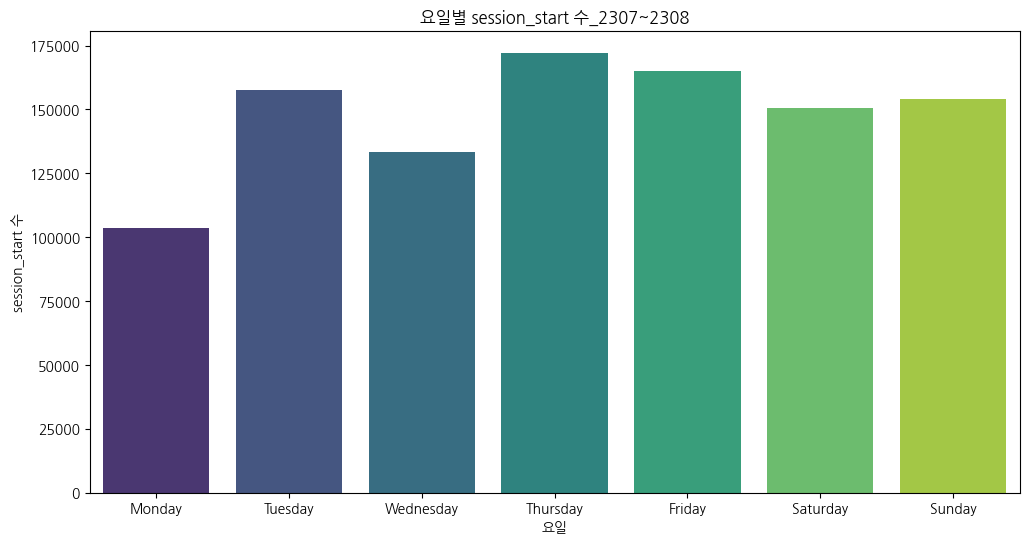

In [39]:
# session_id별로 event_key가 session_start인 경우의 요일, 시간대 알아내기
session_start_df = hackle_events_df[hackle_events_df['event_key'] == '$session_start'].copy()

# 요일별로 session_start 수 집계
session_start_week_counts = session_start_df.groupby(['event_day_of_week', 'event_day_name']).size().reset_index(name='session_start_count')
display(session_start_week_counts)
display(session_start_week_counts['session_start_count'].describe())

# 요일별로 session_start 수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data = session_start_week_counts, x = 'event_day_of_week', y = 'session_start_count', palette='viridis')
plt.title('요일별 session_start 수_2307~2308')
plt.xlabel('요일')
plt.ylabel('session_start 수')   
plt.xticks(ticks = range(7), labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()  
                                                                                                                                                                                                                                                               

,event_hour,count
0,0,60560
1,1,42052
2,2,26708
3,3,15375
4,4,8228
5,5,5714
6,6,7192
7,7,16187
8,8,24154
9,9,25329


count        24.000000
mean      43202.166667
std       26676.819856
min        5714.000000
25%       25035.250000
50%       38731.000000
75%       62775.000000
max      103491.000000
Name: count, dtype: float64

/tmp/ipykernel_64348/2454863591.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = session_start_hour_counts, x = 'event_hour', y = 'count', palette='viridis')


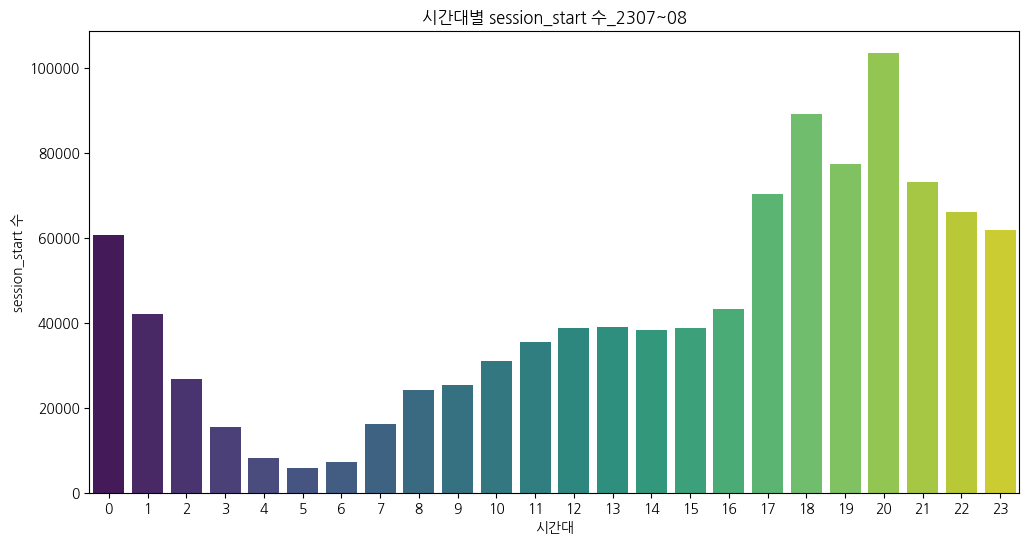

In [47]:
# 시간대별로 session_start 이벤트 개수 집계
session_start_hour_counts = session_start_df['event_hour'].value_counts().sort_index().reset_index()
display(session_start_hour_counts)
display(session_start_hour_counts['count'].describe())

# 시간대별로 session_start 이벤트 개수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data = session_start_hour_counts, x = 'event_hour', y = 'count', palette='viridis')
plt.title('시간대별 session_start 수_2307~08')
plt.xlabel('시간대')   
plt.ylabel('session_start 수')   
plt.show()    

# 지표 도출_세션 지속 시간

In [ ]:
# 파일 불러오기 (properties + events 파일로!)
# 경로 설정
file_path = "gs://part4_project/hackle/merged_pro_events_df.parquet"
key_path = "../config/codeit_project_vm_key.json"

# GCS에서 parquet 불러오기
user_events_df = pd.read_parquet(file_path, storage_options={"token": key_path})

# 확인
print(user_events_df.shape)

(17446765, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 17446765 entries, 0 to 27333184
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         object        
 1   event_id        object        
 2   event_datetime  datetime64[ms]
 3   event_key       object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 1.6+ GB
None


In [20]:
show_df_info(user_events_df, 'user_events_df')


user_events_df 형태:


(17446765, 11)


user_events_df 첫 5행:


,user_id,event_id,event_datetime,event_key,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,unknown,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
1,1041414,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
3,1046711,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
4,unknown,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
6,1545130,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN



user_events_df 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 17446765 entries, 0 to 27333184
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         object        
 1   event_id        object        
 2   event_datetime  datetime64[ms]
 3   event_key       object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 1.6+ GB

user_events_df 통계 요약:


,event_datetime,friend_count,votes_count,heart_balance,question_id
count,17446765,1.597769e+07,1.597376e+07,1.602426e+07,583042.000000
mean,2023-07-29 06:09:48.836000,5.420305e+01,2.509344e+02,1.374616e+04,2748.895869
min,2023-07-18 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,99.000000
25%,2023-07-23 00:56:50,3.200000e+01,9.500000e+01,4.180000e+02,1396.000000
50%,2023-07-28 17:40:45,4.900000e+01,2.060000e+02,1.172000e+03,2548.000000
75%,2023-08-04 21:10:36,7.100000e+01,3.540000e+02,2.926000e+03,4444.000000
max,2023-08-10 23:59:59,1.365000e+03,3.017000e+03,8.849998e+08,5133.000000
std,NaN,3.316540e+01,2.112239e+02,2.858313e+06,1591.425721



user_events_df 통계 요약:


,user_id,event_id,event_key,id,item_name,page_name
count,17446765,17446765,17446765,17446765,17446765,17446765
unique,327381,11441319,44,11441319,6,13
top,unknown,22aea1e5-d090-4b46-97e0-d99b7088f9c8,view_lab_tap,22aea1e5-d090-4b46-97e0-d99b7088f9c8,,
freq,2595741,6,1970877,6,17424809,16286248



user_events_df 결측치 확인:


user_id                  0
event_id                 0
event_datetime           0
event_key                0
id                       0
item_name                0
page_name                0
friend_count       1469073
votes_count        1473010
heart_balance      1422504
question_id       16863723
dtype: int64

In [19]:
# user_id에 공백만 입력된 경우 'unknown'으로 변경
user_events_df['user_id'] = user_events_df['user_id'].apply(lambda x: 'unknown' if isinstance(x, str) and x.strip() == '' else x)
user_events_df['user_id'].value_counts()

user_id
unknown                         2595741
1134987                           17526
1253311                            6551
1154672                            6548
1241875                            5725
                                 ...   
OfvJowO3E3VjtwPE7OG7uKxNzN72          1
41za1T7IYESTtwhVZSVuwzOLlY22          1
yiFYf7rswOh14R9IoFoLmmBDLRm1          1
1463572                               1
xOtCkQsbwnY9j3rjsfnYx3x0i3G3          1
Name: count, Length: 327381, dtype: int64

In [21]:
# user_id가 공백인 경우는 제거 
user_events_df = user_events_df[user_events_df['user_id'] != 'unknown']
user_events_df.shape

(14851024, 11)

## 세션 관련 EDA (세션 시작과 끝을 무엇으로 볼 것인가?)

### session start/end 개수 기반 탐색

In [ ]:
# 세션 아이디 별로 event_key별 개수 확인 
group_session_event_cnt_df = hackle_events_df.groupby('session_id')['event_key'].value_counts().reset_index(name='count')
print(group_session_event_cnt_df.shape)
group_session_event_cnt_df.head()

(2804315, 3)


,session_id,event_key,count
0,000137bc-80de-4bb5-b61d-df7f217a4501,launch_app,1
1,000137bc-80de-4bb5-b61d-df7f217a4501,$session_start,1
2,00025EE1-BA46-4853-8FDD-B991FABA328F,view_timeline_tap,6
3,00025EE1-BA46-4853-8FDD-B991FABA328F,view_lab_tap,6
4,00025EE1-BA46-4853-8FDD-B991FABA328F,click_notice_detail,6


In [49]:
group_session_event_cnt_df['session_id'].nunique() # session_id 253616 개 

253616

In [47]:
# event_key가 session_start와 session_end인 경우만 필터링
group_session_start_end_df = group_session_event_cnt_df[group_session_event_cnt_df['event_key'].isin(['$session_start', '$session_end'])]

# session_id별로 session_start와 session_end의 개수 확인 
pivot_session_start_end_df = group_session_start_end_df.pivot(index='session_id', columns='event_key', values='count').fillna(0).reset_index()

# 결과 확인
show_df_info(pivot_session_start_end_df,'pivot_session_start_end_df')


pivot_session_start_end_df 형태:


(252883, 3)


pivot_session_start_end_df 첫 5행:


event_key,session_id,$session_end,$session_start
0,000137bc-80de-4bb5-b61d-df7f217a4501,0.0,1.0
1,00025EE1-BA46-4853-8FDD-B991FABA328F,0.0,3.0
2,00039F52-AC9A-4474-A645-DFE225C56753,0.0,1.0
3,0004482B-03B0-4638-8C5A-C2E49C085C7F,0.0,1.0
4,0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD,2.0,4.0



pivot_session_start_end_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252883 entries, 0 to 252882
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   session_id      252883 non-null  object 
 1   $session_end    252883 non-null  float64
 2   $session_start  252883 non-null  float64
dtypes: float64(2), object(1)
memory usage: 5.8+ MB

pivot_session_start_end_df 통계 요약:


event_key,$session_end,$session_start
count,252883.000000,252883.000000
mean,2.569006,4.100125
std,7.389767,7.616743
min,0.000000,0.000000
25%,1.000000,2.000000
50%,1.000000,2.000000
75%,2.000000,4.000000
max,285.000000,284.000000



pivot_session_start_end_df 통계 요약:


event_key,session_id
count,252883
unique,252883
top,000137bc-80de-4bb5-b61d-df7f217a4501
freq,1



pivot_session_start_end_df 결측치 확인:


event_key
session_id        0
$session_end      0
$session_start    0
dtype: int64

- 전체 고유한 session_id 253616개 중에, session_start/end 가 없는 session_id 733개 (약 0.29 %)
- session_start가 있어도 session_end는 없는 경우도 존재
- session_start와 session_end 개수 max 값이 비정상적으로 큼?! 

In [45]:
# session_start/end 별 0 개수 
print((pivot_session_start_end_df['$session_start'] == 0).sum())
print((pivot_session_start_end_df['$session_end'] == 0).sum())

6
51334


- session_start는 거의 0이 없음 (6개)
- session_end는 0인 경우가 많음

In [74]:
# session_start는 0이고 session_end는 1이상인 경우
print(((pivot_session_start_end_df['$session_start'] == 0) & (pivot_session_start_end_df['$session_end'] >= 1)).sum())

# session_end가 0이고 session_start는 1이상인 경우 
print(((pivot_session_start_end_df['$session_end'] == 0) & (pivot_session_start_end_df['$session_start'] >= 1)).sum())

6
51334


- sesion_start가 찍히지 않고 session_end만 있는 경우 6개 
- session_end가 찍히지 않고 session_start만 있는 경우 51334개 (약 20.3%)

In [ ]:
# session_start와 session_end 개수가 동일한 경우 추출 
pivot_session_start_end_df[pivot_session_start_end_df['$session_end'] == pivot_session_start_end_df['$session_start']] 

event_key,session_id,$session_end,$session_start
30,001B9F54-531A-4460-9440-526CC96F2463,2.0,2.0
94,005C4D5D-BF73-428A-96D0-160B200497E3,3.0,3.0
141,008DAA55-8DF3-4405-9E11-D4A95E76825C,178.0,178.0
156,009l5WfLYVTlVCItggiEJyKwWtv2,1.0,1.0
275,00kFYscZytOemEnsUJjkVmgtwNP2,2.0,2.0
...,...,...,...
252414,zqDRFKkjlvZSePNWWHdhDrcITLZ2,4.0,4.0
252445,zqxoadIXYCMnteAw85HIwgBcRyb2,2.0,2.0
252446,zqzSSNaGHkPNTh2VZBxiS3Vjm382,2.0,2.0
252637,zugUBuAPZiOpH5CWXeSbGAriJaN2,2.0,2.0


- 252883개 session_id 중에 3924개만 session_start와 session_end 개수가 동일함 (약 1.55%)

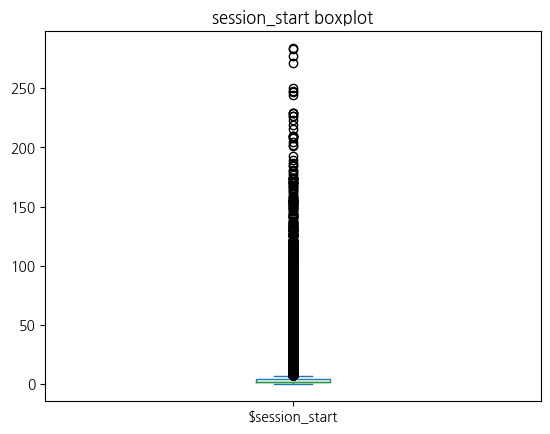

In [88]:
pivot_session_start_end_df['$session_start'].plot(kind = 'box')
plt.title('session_start boxplot')
plt.show()

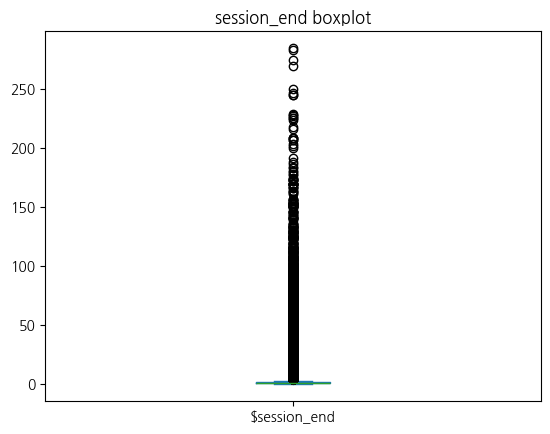

In [89]:
pivot_session_start_end_df['$session_end'].plot(kind = 'box')
plt.title('session_end boxplot')
plt.show()

In [97]:
# 이상치 확인하기
q3 = pivot_session_start_end_df['$session_start'].quantile(0.75)
q1 = pivot_session_start_end_df['$session_start'].quantile(0.25)
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

# 이상치 행 탐색
pivot_session_start_end_df[(pivot_session_start_end_df['$session_start'] >= upper) | ((pivot_session_start_end_df['$session_start'] <= lower))]
    

event_key,session_id,$session_end,$session_start
5,00057831-A672-4163-9C02-AB920A371F2C,6.0,8.0
9,000C66B7-BD0A-4238-9560-A86E4A3A60A4,5.0,7.0
16,00132348-2ae9-4622-96ab-eabca19e1899,16.0,18.0
18,001384f2-7407-479c-a260-c5b525549274,4.0,7.0
22,00150b66-4b8c-44aa-9005-e4fbdda9506e,51.0,54.0
...,...,...,...
252838,zz8I7PEUOiS7P3Yd0gpqwoa47En2,15.0,17.0
252845,zzM1vj0lTSaztBEYG8yoV8NptCC3,4.0,8.0
252863,zzeFmOTzkLPa4kJ9kWsWnWRJPML2,13.0,16.0
252870,zzmI60yQ07Y0kHefIyC3NMk8oTX2,6.0,7.0


- 이상치로 분류된 session_id 약 10.67%

In [90]:
# 이상치 확인하기
q3 = pivot_session_start_end_df['$session_end'].quantile(0.75)
q1 = pivot_session_start_end_df['$session_end'].quantile(0.25)
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

# 이상치 행 탐색
pivot_session_start_end_df[(pivot_session_start_end_df['$session_end'] >= upper) | ((pivot_session_start_end_df['$session_end'] <= lower))]
    

event_key,session_id,$session_end,$session_start
5,00057831-A672-4163-9C02-AB920A371F2C,6.0,8.0
6,000638C3-2BC2-4068-A482-861B526B2651,4.0,5.0
9,000C66B7-BD0A-4238-9560-A86E4A3A60A4,5.0,7.0
16,00132348-2ae9-4622-96ab-eabca19e1899,16.0,18.0
18,001384f2-7407-479c-a260-c5b525549274,4.0,7.0
...,...,...,...
252840,zz9NMJdDkRaXsS6XXchFYEsiNyH3,4.0,6.0
252845,zzM1vj0lTSaztBEYG8yoV8NptCC3,4.0,8.0
252863,zzeFmOTzkLPa4kJ9kWsWnWRJPML2,13.0,16.0
252870,zzmI60yQ07Y0kHefIyC3NMk8oTX2,6.0,7.0


- 이상치로 분류된 session_id 약 13.07%

### session start/end 페어링 기반 탐색

In [23]:
# 필요한 컬럼만 추출
session_df = user_events_df[user_events_df['event_key'].isin(['$session_start', '$session_end'])][['user_id','event_key','event_datetime']]
show_df_info(session_df,'session_df')


session_df 형태:


(2168664, 3)


session_df 첫 5행:


,user_id,event_key,event_datetime
1,1041414,$session_start,2023-07-18 19:40:17
13,LztzUUFoRxdqTSPgQrX3MAAyNkM2,$session_end,2023-07-29 18:39:10
14,1344205,$session_end,2023-07-29 18:39:10
37,1527252,$session_start,2023-07-23 21:03:31
40,1428479,$session_end,2023-08-08 13:08:19



session_df 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 2168664 entries, 1 to 27333184
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         object        
 1   event_key       object        
 2   event_datetime  datetime64[ms]
dtypes: datetime64[ms](1), object(2)
memory usage: 66.2+ MB

session_df 통계 요약:


,event_datetime
count,2168664
mean,2023-07-28 04:01:26.521000
min,2023-07-18 00:00:00
25%,2023-07-21 20:12:46
50%,2023-07-27 17:48:21
75%,2023-08-03 11:47:53
max,2023-08-10 23:59:58



session_df 통계 요약:


,user_id,event_key
count,2168664,2168664
unique,326940,2
top,1239557,$session_start
freq,573,1339152



session_df 결측치 확인:


user_id           0
event_key         0
event_datetime    0
dtype: int64

In [25]:
# session_df 정렬 
session_df = session_df.sort_values(by=['user_id', 'event_datetime']).reset_index(drop=True)

matched_sessions = []

for user_id, group in session_df.groupby('user_id'):
    starts = []
    used_indices = set()
    group = group.sort_values(by='event_datetime').reset_index(drop=True)

    for idx, row in group.iterrows():
        if row['event_key'] == '$session_start':
            starts.append({
                'index': idx,
                'start_time': row['event_datetime'],
                'end_time': pd.NaT,
                'matched': False
            })

    for idx, row in group.iterrows():
        if row['event_key'] == '$session_end':
            # 가능한 start 중 end보다 같거나 작고, 아직 매칭되지 않은 가장 최근 start 찾기
            candidates = [s for s in starts if not s['matched'] and s['start_time'] <= row['event_datetime']]
            if candidates:
                latest_start = max(candidates, key=lambda x: x['start_time'])
                latest_start['end_time'] = row['event_datetime']
                latest_start['matched'] = True
            else:
                # 매칭 안 되는 end는 따로 기록
                matched_sessions.append({
                    'user_id': user_id,
                    'start_time': pd.NaT,
                    'end_time': row['event_datetime'],
                    'session_duration_sec': np.nan
                })

    # 최종 세션 리스트로 구성
    for s in starts:
        matched_sessions.append({
            'user_id': user_id,
            'start_time': s['start_time'],
            'end_time': s['end_time'],
            'session_duration_sec': (
                (s['end_time'] - s['start_time']).total_seconds() if pd.notna(s['end_time']) else np.nan
            )
        })

matched_session_df = pd.DataFrame(matched_sessions)
matched_session_df = matched_session_df.sort_values(by=['user_id', 'start_time', 'end_time']).reset_index(drop=True)

print(matched_session_df.shape)


(1343477, 4)


In [26]:
# matched_session_id 기본 사항 확인 
show_df_info(matched_session_df,'matched_session_df')


matched_session_df 형태:


(1343477, 4)


matched_session_df 첫 5행:


,user_id,start_time,end_time,session_duration_sec
0,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-18 11:17:19,2023-07-18 11:17:19,0.0
1,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-18 11:17:20,2023-07-18 11:17:56,36.0
2,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-19 21:22:08,2023-07-19 21:23:34,86.0
3,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-21 19:34:45,2023-07-21 19:34:46,1.0
4,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-23 14:42:38,NaT,NaN



matched_session_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343477 entries, 0 to 1343476
Data columns (total 4 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   user_id               1343477 non-null  object        
 1   start_time            1339152 non-null  datetime64[ns]
 2   end_time              829512 non-null   datetime64[ns]
 3   session_duration_sec  825187 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 41.0+ MB

matched_session_df 통계 요약:


,start_time,end_time,session_duration_sec
count,1339152,829512,8.251870e+05
mean,2023-07-28 10:02:40.121568256,2023-07-27 18:18:16.979572480,1.635385e+03
min,2023-07-18 00:00:00,2023-07-18 00:00:00,0.000000e+00
25%,2023-07-21 22:36:56.750000128,2023-07-21 16:52:33.500000,0.000000e+00
50%,2023-07-27 19:07:35,2023-07-26 20:14:34.500000,1.400000e+01
75%,2023-08-03 22:07:14,2023-08-02 14:55:38.500000,1.120000e+02
max,2023-08-10 23:59:58,2023-08-10 23:59:54,1.972598e+06
std,NaN,NaN,2.933700e+04



matched_session_df 통계 요약:


,user_id
count,1343477
unique,326940
top,1239557
freq,287



matched_session_df 결측치 확인:


user_id                      0
start_time                4325
end_time                513965
session_duration_sec    518290
dtype: int64

In [ ]:
518290 / 1343477 * 100 # 전체 행의 약 47% 결측치 -> 37% -> user_id로 바꾸면 38.6%

38.5782562708554

In [28]:
matched_session_df.head(10)

,user_id,start_time,end_time,session_duration_sec
0,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-18 11:17:19,2023-07-18 11:17:19,0.0
1,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-18 11:17:20,2023-07-18 11:17:56,36.0
2,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-19 21:22:08,2023-07-19 21:23:34,86.0
3,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-21 19:34:45,2023-07-21 19:34:46,1.0
4,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-23 14:42:38,NaT,NaN
5,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-30 11:01:06,2023-07-30 11:01:38,32.0
6,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-30 11:38:07,2023-07-30 11:39:38,91.0
7,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-31 02:56:13,2023-07-31 02:56:22,9.0
8,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-08-01 00:06:00,2023-08-01 00:06:05,5.0
9,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-08-02 11:53:25,2023-08-02 11:53:27,2.0


In [ ]:
# session 매칭 확인 
# session_id == 003C3A7D-E37A-43DE-B34D-BDB80CFBAB2B
# session_id == 0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD
matched_session_df[matched_session_df['session_id'] == '0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD']

,session_id,start_time,end_time,session_duration_sec
6,0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD,2023-07-26 18:53:38,2023-07-26 18:53:57,19.0
7,0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD,2023-07-26 18:54:00,NaT,NaN
8,0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD,2023-08-07 15:56:16,2023-08-07 15:56:16,0.0
9,0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD,2023-08-07 20:31:04,NaT,NaN


In [13]:
#ackle_events_df[hackle_events_df['session_id'] == '0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD'].sort_values('event_datetime')

## session_start, session_end 중 하나만 있는 경우 보정

In [ ]:
'''
session_start와 session_end 가 짝지어진 것으로 부터 구하기

- session_end 없는 경우          
session_end와 바로 직전 event의 시간 차이를 구하고, 그 시간차의 평균,중앙값 등으로 end 없는 경우 보정
-> 이걸 할 때 지금 match_session_df 기준으로 하면 결국 start_time + 값 인데, 그럼 실제 로그는 

- session_start 없는 경우
session_start와 바로 직후 event의 시간 차이로 보정! 
'''

In [29]:
# start_time과 end_time 모두 있는 경우 : matched
# start만 : start_only
# end만 : end_only

# 페어링 여부 컬럼 추가 
def check_matched(row):
    if pd.notnull(row['start_time']) and pd.notnull(row['end_time']):
        return 'matched'
    elif pd.notnull(row['start_time']) and pd.isna(row['end_time']):
        return 'start_only'
    elif pd.isna(row['start_time']) and pd.notnull(row['end_time']):
        return 'end_only'
    else:
        return 'unknown'

matched_session_df['session_flag'] = matched_session_df.apply(check_matched, axis=1) 
print(matched_session_df.shape)
matched_session_df.head()

(1343477, 5)


,user_id,start_time,end_time,session_duration_sec,session_flag
0,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-18 11:17:19,2023-07-18 11:17:19,0.0,matched
1,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-18 11:17:20,2023-07-18 11:17:56,36.0,matched
2,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-19 21:22:08,2023-07-19 21:23:34,86.0,matched
3,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-21 19:34:45,2023-07-21 19:34:46,1.0,matched
4,001zjRPEGWWVou4CbhLU7JQ9K9W2,2023-07-23 14:42:38,NaT,NaN,start_only


In [30]:
# session_flag 별 확인
print('\nsession 매칭 여부 별 개수')
print(matched_session_df['session_flag'].value_counts())
print('\nsession 매칭 여부 별 개수 비율')
print(matched_session_df['session_flag'].value_counts(normalize=True))  # 비율


session 매칭 여부 별 개수
session_flag
matched       825187
start_only    513965
end_only        4325
Name: count, dtype: int64

session 매칭 여부 별 개수 비율
session_flag
matched       0.614217
start_only    0.382563
end_only      0.003219
Name: proportion, dtype: float64


### start_only, end_only 보정? 
- 직전 이벤트와 end_time의 시간 차이, 직후 이벤트와 start_time의 시간 차이 구해서 판단하기

In [ ]:
# 전체 hackle_events에서 start_time과 직후 이벤트 차이, end_time과 직전 이벤트 차이 구해보기 
# user_events_df에서 event_key가 session_start인 것과 직후 이벤트, session_end 인 것과 직전 이벤트만 추출해오기

 

In [36]:
# 1) session_start, session_end만 추출
start_events = user_events_df[user_events_df['event_key'] == 'session_start'].copy()
end_events = user_events_df[user_events_df['event_key'] == 'session_end'].copy()

# 2) user_events_df를 시간 기준 정렬 (만약 정렬이 안 되어 있으면)
user_events_df = user_events_df.sort_values(['user_id', 'event_datetime']).reset_index(drop=True)

# 3) session_start 이벤트 다음 이벤트 찾기
# 우선 전체 이벤트에서 shift(-1)으로 다음 이벤트 가져오기
user_events_df['next_event_key'] = user_events_df['event_key'].shift(-1)
user_events_df['next_event_time'] = user_events_df['event_datetime'].shift(-1)
user_events_df['prev_event_key'] = user_events_df['event_key'].shift(1)
user_events_df['prev_event_time'] = user_events_df['event_datetime'].shift(1)

# 4) start 이벤트에서 다음 이벤트와 시간차 계산
start_events = user_events_df[user_events_df['event_key'] == 'session_start'].copy()
start_events['time_to_next'] = (start_events['next_event_time'] - start_events['event_datetime']).dt.total_seconds()

# 5) end 이벤트에서 이전 이벤트와 시간차 계산
end_events = user_events_df[user_events_df['event_key'] == 'session_end'].copy()
end_events['time_from_prev'] = (end_events['event_datetime'] - end_events['prev_event_time']).dt.total_seconds()

# 6) 결과 확인
print("Start events + next event 시간차 분포")
print(start_events['time_to_next'].describe())

print("End events + prev event 시간차 분포")
print(end_events['time_from_prev'].describe())


: 